/home/andreasstillits/coding/Leaves1D/supplementary/notebooks
/home/andreasstillits/coding/Leaves1D


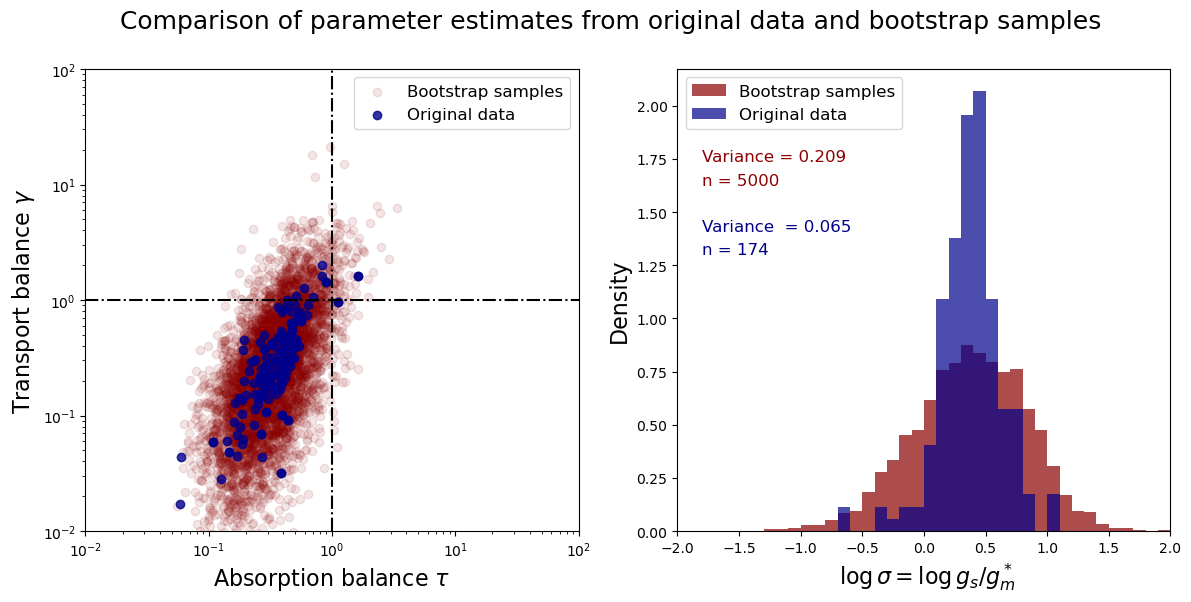

In [3]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd  

np.random.seed(42)  # for reproducibility

%cd "/home/andreasstillits/coding/Leaves1D/supplementary/notebooks"

df = pd.read_csv("../files/data/Knauer2022_pre_tau_gamma.csv", decimal=',', sep=';')

gs = df["stomatal_conductance"].to_numpy()
L = df["mesophyll_thickness"].to_numpy()
Dias = df["ias_conductance"].to_numpy() * L
gias = Dias / L
gm = df["mesophyll_conductance*"].to_numpy()

%cd "/home/andreasstillits/coding/Leaves1D/"
from python_module.interface import numpy_estimate_parameters

taus, gammas = numpy_estimate_parameters(gm, gs, gias)
log_sigmas = np.log10((gammas / (taus * np.tanh(taus))))



# bootstrap sampling

num_samples = 5_000 

# Sample from the distributions of gs, gias, and gm by randomly drawing values from the arrays with replacement
# gs_samples = np.random.choice(gs, size=num_samples, replace=True)
# gias_samples = np.random.choice(gias, size=num_samples, replace=True)
# gm_samples = np.random.choice(gm, size=num_samples, replace=True)

gs_samples = np.random.choice(gs, size=num_samples, replace=True)
L_samples = np.random.choice(L, size=num_samples, replace=True)
Dias_samples = np.random.choice(Dias, size=num_samples, replace=True)
gias_samples = Dias_samples / L_samples
gm_samples = np.random.choice(gm, size=num_samples, replace=True)

taus_samples, gammas_samples = numpy_estimate_parameters(gm_samples, gs_samples, gias_samples)
log_sigmas_samples = np.log10(gammas_samples / (taus_samples * np.tanh(taus_samples)))



figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.scatter(taus_samples, gammas_samples, marker="o", color="darkred", alpha=0.1, label="Bootstrap samples")
ax1.scatter(taus, gammas, marker="o", color="darkblue", alpha=0.8, label="Original data")
ax1.set_xlabel(r"Absorption balance $\tau$", fontsize=16)
ax1.set_ylabel(r"Transport balance $\gamma$", fontsize=16) 
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlim(0.01, 100)
ax1.set_ylim(0.01, 100)
ax1.plot([1, 1], [0.01, 100], color="black", linestyle="-.")
ax1.plot([0.01, 100], [1, 1], color="black", linestyle="-.")
ax1.legend(fontsize=12)


xmin, xmax = -2, 2  
n_bins = 4*10  # number of bins

# log-spaced bin edges
bins = np.linspace(xmin, xmax, n_bins+1)

ax2.hist(log_sigmas_samples, bins=bins, alpha=0.7, label="Bootstrap samples",
         color="darkred", density=True)
ax2.hist(log_sigmas,         bins=bins, alpha=0.7, label="Original data",
         color="darkblue", density=True)

ax2.set_xlim(xmin, xmax)
ax2.set_xlabel(r" $\log \sigma = \log g_s/g_m^*$", fontsize=16)
ax2.set_ylabel("Density", fontsize=16)
# annotate variances of the two distributions
var_original = np.var(log_sigmas)
var_bootstrap = np.var(log_sigmas_samples)
ax2.text(-1.8, 0.80 * ax2.get_ylim()[1], f"Variance = {var_bootstrap:.3f}", color="darkred", fontsize=12)
ax2.text(-1.8, 0.75 * ax2.get_ylim()[1], "n = 5000", color="darkred", fontsize=12)
ax2.text(-1.8, 0.65 * ax2.get_ylim()[1], f"Variance  = {var_original:.3f}", color="darkblue", fontsize=12)
ax2.text(-1.8, 0.60 * ax2.get_ylim()[1], f"n = {len(log_sigmas)}", color="darkblue", fontsize=12)
ax2.legend(fontsize=12)

plt.suptitle("Comparison of parameter estimates from original data and bootstrap samples", fontsize=18)
plt.savefig("supplementary/figures/bias_bootstrap.jpg", dpi=900)
plt.show()


In [2]:
# calculate the p value that the two distributions are different
from scipy.stats import ks_2samp
ks_statistic, p_value = ks_2samp(log_sigmas, log_sigmas_samples)
print(f"KS statistic: {ks_statistic:.4f}, p-value: {p_value:.2e}")

# compare the variances of the two distributions
var_original = np.var(log_sigmas)
var_samples = np.var(log_sigmas_samples)
print(f"Variance of original data: {var_original:.4f}")
print(f"Variance of bootstrap samples: {var_samples:.4f}")

KS statistic: 0.1771, p-value: 4.40e-05
Variance of original data: 0.0654
Variance of bootstrap samples: 0.2011
